# Solving the SSA without enforcing flotation

This notebook solves the version of the SSA found in Eq. 44 of [MacAyeal et al. (2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3), in which surface and basal elevations may be slightly out of flotational equilibrium. There is no time evolution (velocity and stress fields correspond to the input geometry only and do not approach steady state), rheology is linear, and I hard-code the deviations from equilibrium instead of letting them evolve naturally. The problem is solved first using pure Firedrake, and then the solution is verified with icepack. Good agreement between the two indicates that I'm modifying icepack correctly. 

## Method 1: just Firedrake

In their [linear elasticity tutorial](https://github.com/firedrakeproject/firedrake/blob/master/docs/notebooks/03-elasticity.ipynb), the variational form to be solved by Firedrake is written 

$$\int_\Omega \vec{\sigma} : \nabla\vec{v} d\Omega - \int_\Gamma (\vec{\sigma}\cdot\vec{n})\cdot\vec{v} d\Gamma = \int_\Omega \vec{f}\cdot \vec{v}d\Omega,$$

where the stress tensor $\vec{\sigma}$ relates to the displacement field via the standard constitutive relation for elastic materials. The SSA can be put directly into this form by substituting the depth-integrated net stress, $H\overline{\sigma}$, in place of $\vec{\sigma}$, and noting that the component of the body force acting along the $xy$ plane is zero. This yields the form

$$\int_\Omega H\overline{\sigma} : \nabla\vec{v}d\Omega - \int_\Gamma (H\overline{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma = 0.$$

We start by importing Firedrake and building a mesh:

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors 

nx, ny = 100, 50 #number of elements in x and y
Lx, Ly = 10000, 5000 #length, width of shelf in meters
H_gl = 600 #thickness of shelf at the grounding line (meters)
thick_grad = -0.01 #thickness gradient 
mesh = RectangleMesh(100, 50, Lx, Ly)

### Show the mesh
Uncomment to show the mesh.

In [2]:
# coords = mesh.coordinates.dat.data
# fig, ax = plt.subplots()
# ax.triplot(coords[:,0], coords[:,1], color='k', linewidth=0.5)
# plt.xlabel('x coordinate (m)', fontsize=16)
# plt.ylabel('y coordinate (m)', fontsize=16)

### Define function spaces, spatial variables

In [3]:
V = VectorFunctionSpace(mesh, 'CG', 2) #for interpolating vector functions (velocity, etc.)
Q = FunctionSpace(mesh, 'CG', 2) #scalar functions (surface elevation, etc.)
S = TensorFunctionSpace(mesh, 'DG', 1) #tensor functions (stress, etc.)

x, y = SpatialCoordinate(mesh)
I = Identity(2) #2-by-2 identity matrix

### Physical constants and spatial parameters
Choosing values consistent with icepack's, with the caveat that icepack uses different units. 

In [4]:
from icepack.constants import year #number of seconds per year
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater (kg/m^3)
g = 9.81 #gravity (N/kg)
ν = 6e13 #somewhat arbitrary viscosity in Pascal*seconds

H = interpolate(H_gl + thick_grad*x, Q) #thickness decreases linearly downstream

### Choose Dirichlet boundary conditions
Define several possible boundary conditions here, and then choose the ones we actually want to use.

In [5]:
sidewalls_y = DirichletBC(V.sub(1), Constant(0), (3, 4)) #no lateral motion through sidewalls
sidewalls_x = DirichletBC(V.sub(0), Constant(0), (3, 4)) #no slip along sidewalls
upstream_y = DirichletBC(V.sub(1), Constant(0), 1) #no lateral motion at the upstream boundary
upstream_x = DirichletBC(V.sub(0), Constant(0), 1) #no longitudinal motion at the upstream boundary

bcs = [upstream_x, upstream_y, sidewalls_x, sidewalls_y] #modify this to solve a different problem

### Is the shelf at flotation?

We'll simulate periodic, flow-perpendicular "rumples." Height above buoyancy, ```h_ab```, will vary as a sine wave with frequency ```freq``` and amplitude ```amp```. Solve the classic SSA by setting ```amp = 0```.

Text(0, 0.5, 'lateral coordinate (m)')

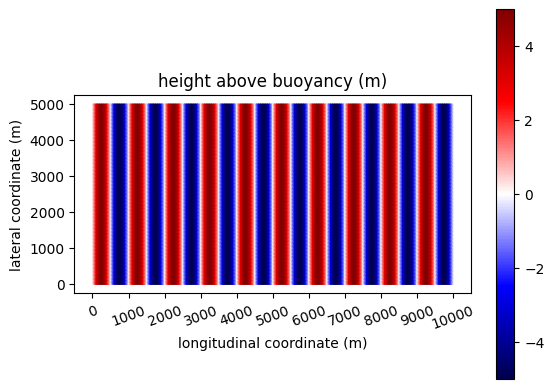

In [6]:
amp = 5 #max vertical deflection in meters (should not ever be more than a few % of the ice thickness)
freq = 10 #total number of rumples we want 
h_ab = interpolate(amp*sin(freq*2*pi*x/Lx), Q) 

s = interpolate((1 - ρ_i/ρ_w)*H + h_ab, Q) #surface elevation is h_ab meters above its equilibrium height
b = interpolate(-ρ_i/ρ_w*H + h_ab, Q) #basal elevation is h_ab meters above its equilibrium height

fig, ax = plt.subplots()
ax.set_aspect('equal')
norm = colors.TwoSlopeNorm(vcenter = 0)
hab_plot = tripcolor(h_ab, axes = ax, norm = norm, cmap = 'seismic')
plt.colorbar(hab_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('height above buoyancy (m)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')

### Constitutive relation

The trick to making the linear elasticity tutorial work for the SSA is the writing of the constitutive relation. Toward writing this relationship, note first that

$$H\overline{\sigma} = \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u})^T + 2(\nabla\cdot\vec{u})\vec{I}\right) - \int_b^s\rho_ig(s-z)dz\vec{I} - \int_b^0\rho_wgzdz\vec{I},$$

where the first term on the right can be physically interpreted as the depth-integrated resistive stress tensor, and the integral terms represent the weight of the ice and water columns. It follows that 

$$H\overline{\sigma} = \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u})^T + 2(\nabla\cdot\vec{u})\vec{I}\right) - \frac{1}{2}\rho_igH^2\vec{I} + \frac{1}{2}\rho_wgb^2\vec{I}.$$

In the special case of perfect flotation, $b = -\frac{\rho_i}{\rho_w}H$, and the above relationship would simplify to 

$$ H\overline{\sigma} = \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u})^T + 2(\nabla\cdot\vec{u})\vec{I}\right) - \frac{1}{2}\rho_i gsH\vec{I}.$$

(This relationship can be naturally enforced by setting the wave amplitude ```amp = 0``` in the cell above.) In the more general formulation, the variational form in the preamble can now be expressed

$$ \int_\Omega \overline{\mu}H\left(\nabla\vec{u} + (\nabla\vec{u}^T) + 2(\nabla\cdot\vec{u})\vec{I}\right):\nabla\vec{v}d\Omega = \int_\Gamma(H\overline{\sigma}\cdot\vec{n})\cdot\vec{v}d\Gamma + \int_{\Omega}\left(\frac{1}{2}\rho_i gH^2\vec{I} - \frac{1}{2}\rho_wgb^2\vec{I}\right):\nabla\vec{v}d\Omega$$



In [7]:
def HR(u): #physically interpreted as the depth-integrated resistive stress tensor, a la van der Veen
    return ν*H*(grad(u) + grad(u).T + 2*div(u)*I)

### Solve the variational problem

In [8]:
u = TrialFunction(V)
v = TestFunction(V)
a = inner(HR(u), grad(v))*dx 
L = inner(1/2*ρ_i*g*H**2*I - 1/2*ρ_w*g*b**2*I, grad(v))*dx #if applicable, add any Neumann BCs to L
#(no need to add the terminal cliff BC here because it's a zero-traction boundary condition anyway)

u_fd = Function(V) #velocity solution (u_x, u_y) from (f)ire(d)rake
solve(a == L,
        u_fd,
        bcs = bcs,
        solver_parameters = {'ksp_monitor':None})

ux_fd = project(u_fd[0], Q) #ux in meters per second
τ_fd = project(ν*grad(u_fd) + ν*grad(u_fd).T, S) #deviatoric stress tensor
τxx_fd = project(τ_fd[0, 0], Q) #τ_xx in Pascals

    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 7.474916331581e+10 
    1 KSP Residual norm 2.034426224474e-02 


### Visualize the results

Text(0, 0.5, 'lateral coordinate (m)')

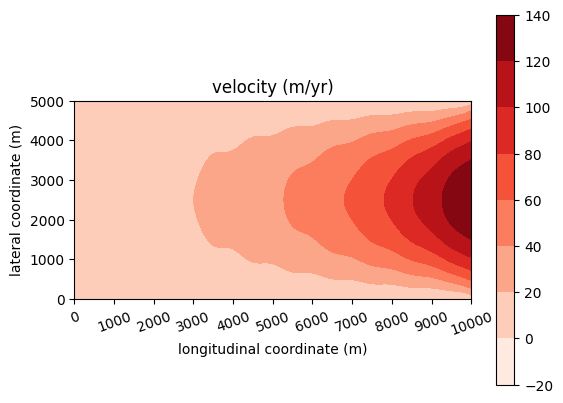

In [9]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
vel_plot = tricontourf(project(ux_fd*year, Q), axes = ax, cmap = 'Reds')
plt.colorbar(vel_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('velocity (m/yr)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')

## Method 2: icepack

In [10]:
import icepack
from icepack.constants import ice_density as ρ_I, water_density as ρ_W, gravity as G #icepack uses different units!
from operator import itemgetter

### Modify icepack's viscosity to allow $n = 1$; modify gravity and terminus to allow $h_{ab} \neq 0$

In [11]:
def viscosity2(**kwargs):
    n = 1 #don't try to change this without also changing A
    A = 1/(2*ν)*1e6*year #get A in /(MPa*yr) consistent with ν in Pa*s
    u, h = itemgetter('velocity', 'thickness')(kwargs)
    ε_min = kwargs.get('strain_rate_min', Constant(icepack.constants.strain_rate_min))
    ε = icepack.calculus.sym_grad(u)
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min)
    return 2*n/(n + 1)*h*A**(-1/n)*ε_e**(1/n + 1)

def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021), but note the sign error!
    u, h, b = itemgetter("velocity", "thickness", "base")(kwargs)
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u) #assume the depth-invariant parts are zero

def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter("velocity", "thickness", "base")(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν) #again, no depth-invariance 

### Choose boundary conditions

In [12]:
#boundary labels: (upstream, downstream, right, left) = (1, 2, 3, 4)
dirichlet_ids = [1, 3, 4]
side_wall_ids = []
ice_front_ids = [2]

### Define the model and solver

In [13]:
model = icepack.models.IceShelf(viscosity = viscosity2, gravity = gravity2, terminus = terminus2,
                               side_friction = icepack.models.friction.side_friction)

solver = icepack.solvers.FlowSolver(model, dirichlet_ids = dirichlet_ids, 
                                    side_wall_ids = side_wall_ids, ice_front_ids = ice_front_ids)

### Solve with icepack

In [14]:
u0 = interpolate(as_vector([1e-50, 1e-50]), V) #1e-50 rather than zero, to avoid a singularity in side friction
C0 = Constant(0.0) #coefficient of sidewall friction for slippery sidewalls

u_ip = solver.diagnostic_solve(velocity = u0, side_friction = C0, thickness = H, base = b)/year #convert to m/s

ux_ip = project(u_ip[0], Q) #u_x in meters per second
τ_ip = project(ν*grad(u_ip) + ν*grad(u_ip).T, S) #deviatoric stress tensor in Pascals
τxx_ip = project(τ_ip[0, 0], Q) #τ_xx in Pascals

### And plot the icepack solution 

Text(0, 0.5, 'lateral coordinate (m)')

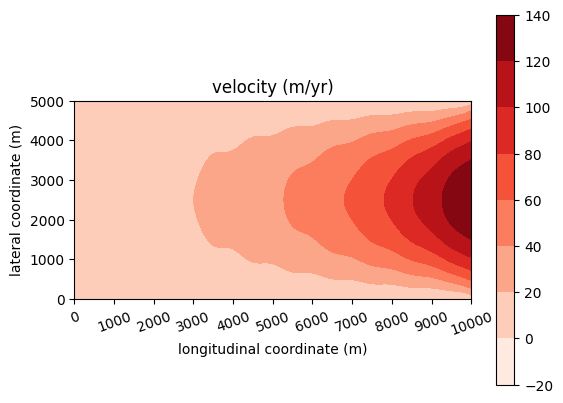

In [15]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
vel_plot = tricontourf(project(ux_ip*year, Q), axes = ax, cmap = 'Reds')
plt.colorbar(vel_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('velocity (m/yr)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')

## Do the two solutions agree?

Text(0, 0.5, 'lateral coordinate (m)')

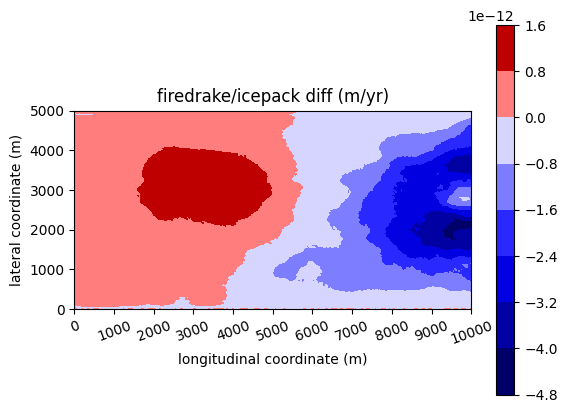

In [16]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
norm = colors.TwoSlopeNorm(vcenter = 0)
diff_plot = tricontourf(project(ux_fd*year - ux_ip*year, Q), axes = ax, cmap = 'seismic', norm = norm)
plt.colorbar(diff_plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('firedrake/icepack diff (m/yr)')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('lateral coordinate (m)')

### If solving uniaxial extension, also compare with analytic solution

For a longitudinally extending shelf in flotational equilibrium, $\tau_{xx} = \frac{1}{4}\rho_igs(x)$. We can generalize this relationship to also describe the shelf in non-equilibrium:

$$ \tau_{xx} = \frac{1}{4}\rho_igH - \frac{1}{4H}\rho_wgb^2$$

Simulate a longitudinally extending shelf with Firedrake by setting ```bcs = [upstream_x, upstream_y, sidewalls_y]```, and with icepack by setting ```dirichlet_ids = [1]```, ```side_wall_ids = [3, 4]```, and ```ice_front_ids = [2]```.

In [17]:
# analytic_general = project((1/4*ρ_i*g*H - 1/4*ρ_w*g*b**2/H), Q) 
# analytic_floating = project(1/4*ρ_i*g*(1 - ρ_i/ρ_w)*H, Q) #if we want a baseline to compare with

# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# norm = colors.TwoSlopeNorm(vcenter = 0)
# diff_plot = tricontourf(project(τxx_ip - analytic_general, Q), axes = ax, cmap = 'seismic', norm = norm)
# plt.colorbar(diff_plot)
# plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
# plt.title('analytic/numerical diff (Pa)')
# plt.xlabel('longitudinal coordinate (m)')
# plt.ylabel('lateral coordinate (m)')